## imports & load files

In [ ]:
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
import shap
import seaborn as sns
import scipy.stats as stats
from datetime import datetime, timedelta
import re
from scipy.stats import linregress, ttest_rel, wilcoxon, zscore
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
#from sklearn.covariance import GraphLassoCV
import networkx as nx
from scipy.stats import spearmanr, kendalltau, pearsonr, shapiro
from statsmodels.miscmodels.ordinal_model import OrderedModel


# Specify the path to the desired directory
parent_dir = r'<<< PLACE HERE DIRECTORY WITH DATASET >>>'

# Change the current working directory to the specified directory
os.chdir(parent_dir)

# Verify that the working directory has been changed
print("Current working directory:", os.getcwd())

avg_ratings = pd.read_csv("all_avg_ratings.csv")

Current working directory: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER


In [3]:
avg_ratings_cleaned = avg_ratings.dropna()  # Drop rows with any NaN values

In [4]:
# Assuming df is avg_ratings_cleaned
avg_ratings_cleaned['avg_ratings_categorical'] = avg_ratings_cleaned['avg_rating'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

# Display the first few rows to check
print(avg_ratings_cleaned[['avg_rating', 'avg_ratings_categorical']].head())

   avg_rating  avg_ratings_categorical
0       0.809                        1
1      -0.045                       -1
2       0.168                        1
3      -0.333                       -1
4       0.500                        1


Spearman's correlation: 0.283, p-value: 0.009
Kendall's Tau: 0.192, p-value: 0.012
Pearson's correlation: 0.298, p-value: 0.006
Shapiro-Wilk Test for avg_rating: W=0.929, p-value=0.000
Shapiro-Wilk Test for post_ride_rating: W=0.969, p-value=0.039


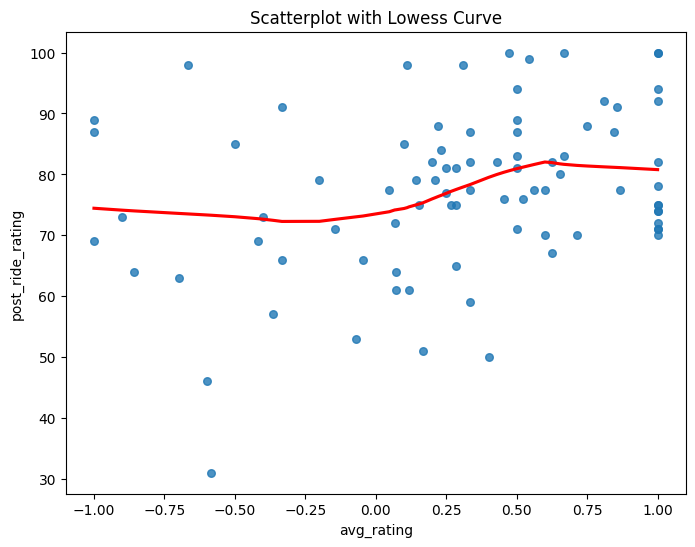

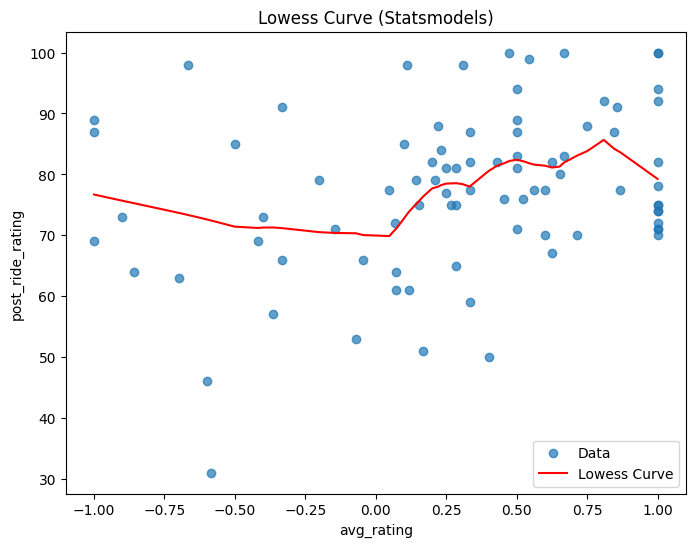

In [ ]:

# Extract relevant columns
x = avg_ratings_cleaned['avg_rating']
y = avg_ratings_cleaned['post_ride_rating']

# 1. Spearman's Rank Correlation
spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman's correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

# 2. Kendall's Tau
kendall_corr, kendall_p = kendalltau(x, y)
print(f"Kendall's Tau: {kendall_corr:.3f}, p-value: {kendall_p:.3f}")

# 3. Pearson's Correlation
pearson_corr, pearson_p = pearsonr(x, y)
print(f"Pearson's correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")

# 5. Check for Normality (Shapiro-Wilk Test)
shapiro_x = shapiro(x)
shapiro_y = shapiro(y)

print(f"Shapiro-Wilk Test for avg_rating: W={shapiro_x.statistic:.3f}, p-value={shapiro_x.pvalue:.3f}")
print(f"Shapiro-Wilk Test for post_ride_rating: W={shapiro_y.statistic:.3f}, p-value={shapiro_y.pvalue:.3f}")


In [5]:

# Extract relevant columns
x = avg_ratings_cleaned['avg_rating']
y = avg_ratings_cleaned['post_ride_rating']

# 1. Spearman's Rank Correlation
spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman's correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

# 2. Kendall's Tau
kendall_corr, kendall_p = kendalltau(x, y)
print(f"Kendall's Tau: {kendall_corr:.3f}, p-value: {kendall_p:.3f}")

# 3. Pearson's Correlation
pearson_corr, pearson_p = pearsonr(x, y)
print(f"Pearson's correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")

# 5. Check for Normality (Shapiro-Wilk Test)
shapiro_x = shapiro(x)
shapiro_y = shapiro(y)

print(f"Shapiro-Wilk Test for avg_rating: W={shapiro_x.statistic:.3f}, p-value={shapiro_x.pvalue:.3f}")
print(f"Shapiro-Wilk Test for post_ride_rating: W={shapiro_y.statistic:.3f}, p-value={shapiro_y.pvalue:.3f}")


Spearman's correlation: 0.283, p-value: 0.009
Kendall's Tau: 0.192, p-value: 0.012
Pearson's correlation: 0.298, p-value: 0.006
Shapiro-Wilk Test for avg_rating: W=0.929, p-value=0.000
Shapiro-Wilk Test for post_ride_rating: W=0.969, p-value=0.039


In [7]:
### important one!!


# Correlation pairs to test
correlation_pairs = [
    ('avg_rating', 'post_ride_rating'),
    ('avg_rating', 'flow'),
    ('avg_rating', 'safety'),
    ('emotion_transitions', 'post_ride_rating'),
    ('emotion_transitions', 'flow'),
    ('emotion_transitions', 'safety'),
    ('flow', 'flowdisposition_numeric')
]

# Collect results
results = []

# Loop through each variable pair
for var1, var2 in correlation_pairs:
    x = avg_ratings_cleaned[var1]
    y = avg_ratings_cleaned[var2]

    # Pearson's correlation
    pearson_corr, pearson_p = pearsonr(x, y)

    # Spearman's correlation
    spearman_corr, spearman_p = spearmanr(x, y)

    # Kendall's Tau
    kendall_corr, kendall_p = kendalltau(x, y)

    # Shapiro-Wilk Test for Normality
    shapiro_x_stat, shapiro_x_p = shapiro(x)
    shapiro_y_stat, shapiro_y_p = shapiro(y)

    # Lowess smoother (for visual/curve insight, not a stat test, just checking shape)
    lowess = sm.nonparametric.lowess(y, x, frac=0.3)
    lowess_trend = "Visual inspection required"

    # Store results
    results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Pearson Corr': pearson_corr,
        'Pearson p': pearson_p,
        'Spearman Corr': spearman_corr,
        'Spearman p': spearman_p,
        'Kendall Corr': kendall_corr,
        'Kendall p': kendall_p,
        'Shapiro-Wilk p (x)': shapiro_x_p,
        'Shapiro-Wilk p (y)': shapiro_y_p,
        'Lowess (visual)': lowess_trend
    })

# Convert to dataframe for convenient display
results_df = pd.DataFrame(results)
results_df

,Variable 1,Variable 2,Pearson Corr,Pearson p,Spearman Corr,Spearman p,Kendall Corr,Kendall p,Shapiro-Wilk p (x),Shapiro-Wilk p (y),Lowess (visual)
0,avg_rating,post_ride_rating,0.298370,0.005838,0.282944,0.009110,0.192239,0.011601,1.819377e-04,3.885674e-02,Visual inspection required
1,avg_rating,flow,0.337429,0.001696,0.307391,0.004451,0.223920,0.004071,1.819377e-04,4.096011e-05,Visual inspection required
2,avg_rating,safety,0.090697,0.411939,0.059627,0.590041,0.044469,0.574856,1.819377e-04,6.868165e-07,Visual inspection required
3,emotion_transitions,post_ride_rating,-0.124308,0.259908,-0.014745,0.894093,0.000000,1.000000,2.636621e-12,3.885674e-02,Visual inspection required
4,emotion_transitions,flow,-0.125059,0.257020,-0.086522,0.433878,-0.069370,0.389022,2.636621e-12,4.096011e-05,Visual inspection required
5,emotion_transitions,safety,-0.164511,0.134814,-0.272719,0.012079,-0.205137,0.012265,2.636621e-12,6.868165e-07,Visual inspection required
6,flow,flowdisposition_numeric,-0.178821,0.103629,-0.215472,0.049019,-0.170484,0.048021,4.096011e-05,3.212090e-08,Visual inspection required


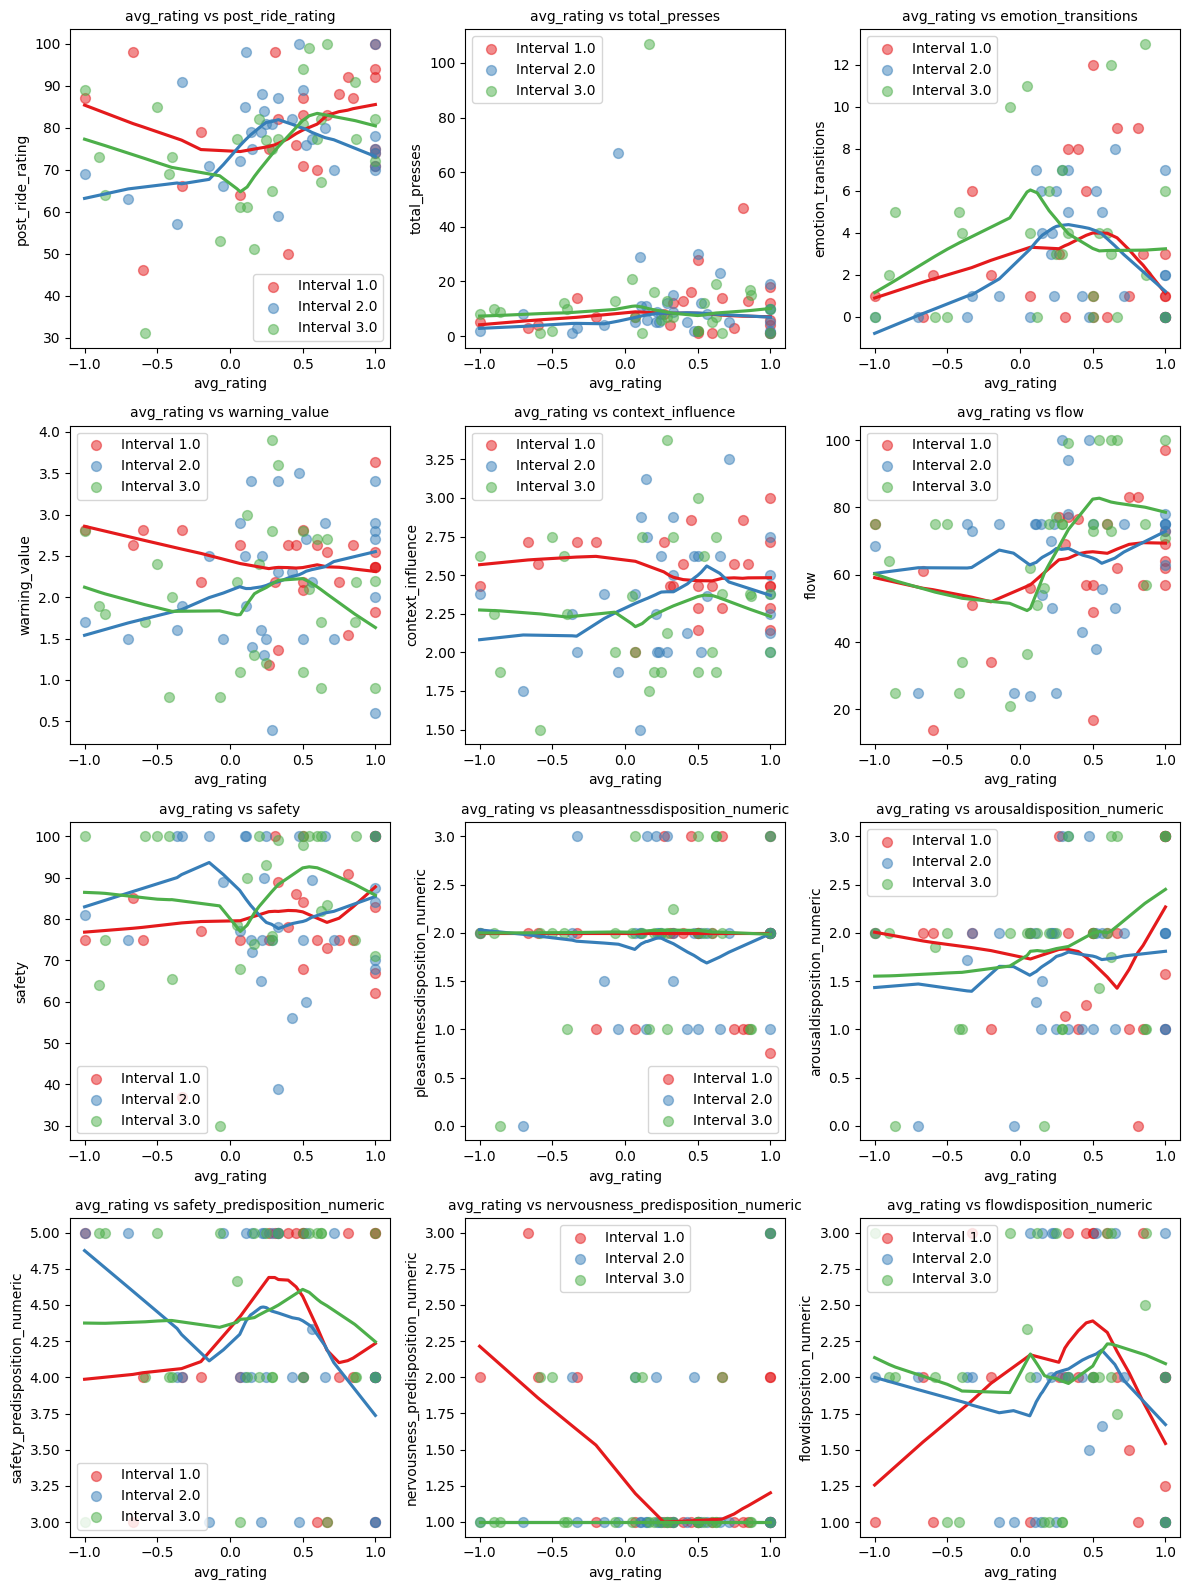

In [ ]:

# List of relationships to plot based on the given formula
plot_relations = [
    ('avg_rating', 'post_ride_rating'),
    ('avg_rating', 'total_presses'),
    #('avg_rating', 'rating_variance'),
    #('avg_rating', 'rating_range'),
    ('avg_rating', 'emotion_transitions'),
    #('avg_rating', 'press_intensity'),
    ('avg_rating', 'warning_value'),
    ('avg_rating', 'context_influence'),
    ('avg_rating', 'flow'),
    ('avg_rating', 'safety'),
    ('avg_rating', 'pleasantnessdisposition_numeric'),
    ('avg_rating', 'arousaldisposition_numeric'),
    ('avg_rating', 'safety_predisposition_numeric'),
    ('avg_rating', 'nervousness_predisposition_numeric'),   
    ('avg_rating', 'flowdisposition_numeric')
    
]

# Determine grid size based on the number of relationships
num_plots = len(plot_relations)
cols = 3  # Keep 3 columns for readability
rows = int(np.ceil(num_plots / cols))  # Calculate required rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # Adjust height dynamically
axes = axes.flatten()  # Flatten the axes array for easy iteration


# Iterate through the list of relationships and plot the scatterplots with LOWESS curves
for idx, (x_col, y_col) in enumerate(plot_relations):
    # Create a filtered dataset if 'emotion_transitions' is involved
    if y_col == 'emotion_transitions' or x_col == 'emotion_transitions':
        data = avg_ratings[avg_ratings['emotion_transitions'] <= 15]
    else:
        data = avg_ratings
    
    # Plot with color based on interval_id
    palette = sns.color_palette('Set1', n_colors=len(data['interval_id'].unique()))
    for i, interval in enumerate(sorted(data['interval_id'].unique())):
        subset = data[data['interval_id'] == interval]
        sns.regplot(data=subset, x=x_col, y=y_col, ax=axes[idx], 
                    scatter_kws={'s': 50, 'color': palette[i], 'alpha': 0.5}, lowess=True, 
                    line_kws={'color': palette[i]}, 
                    label=f'Interval {interval}')
    
    axes[idx].set_title(f'{x_col} vs {y_col}', fontsize=10)
    axes[idx].legend()

# Hide any unused subplots (we only have 6 plots, but the grid is 3x3)
for idx in range(len(plot_relations), len(axes)):
    axes[idx].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

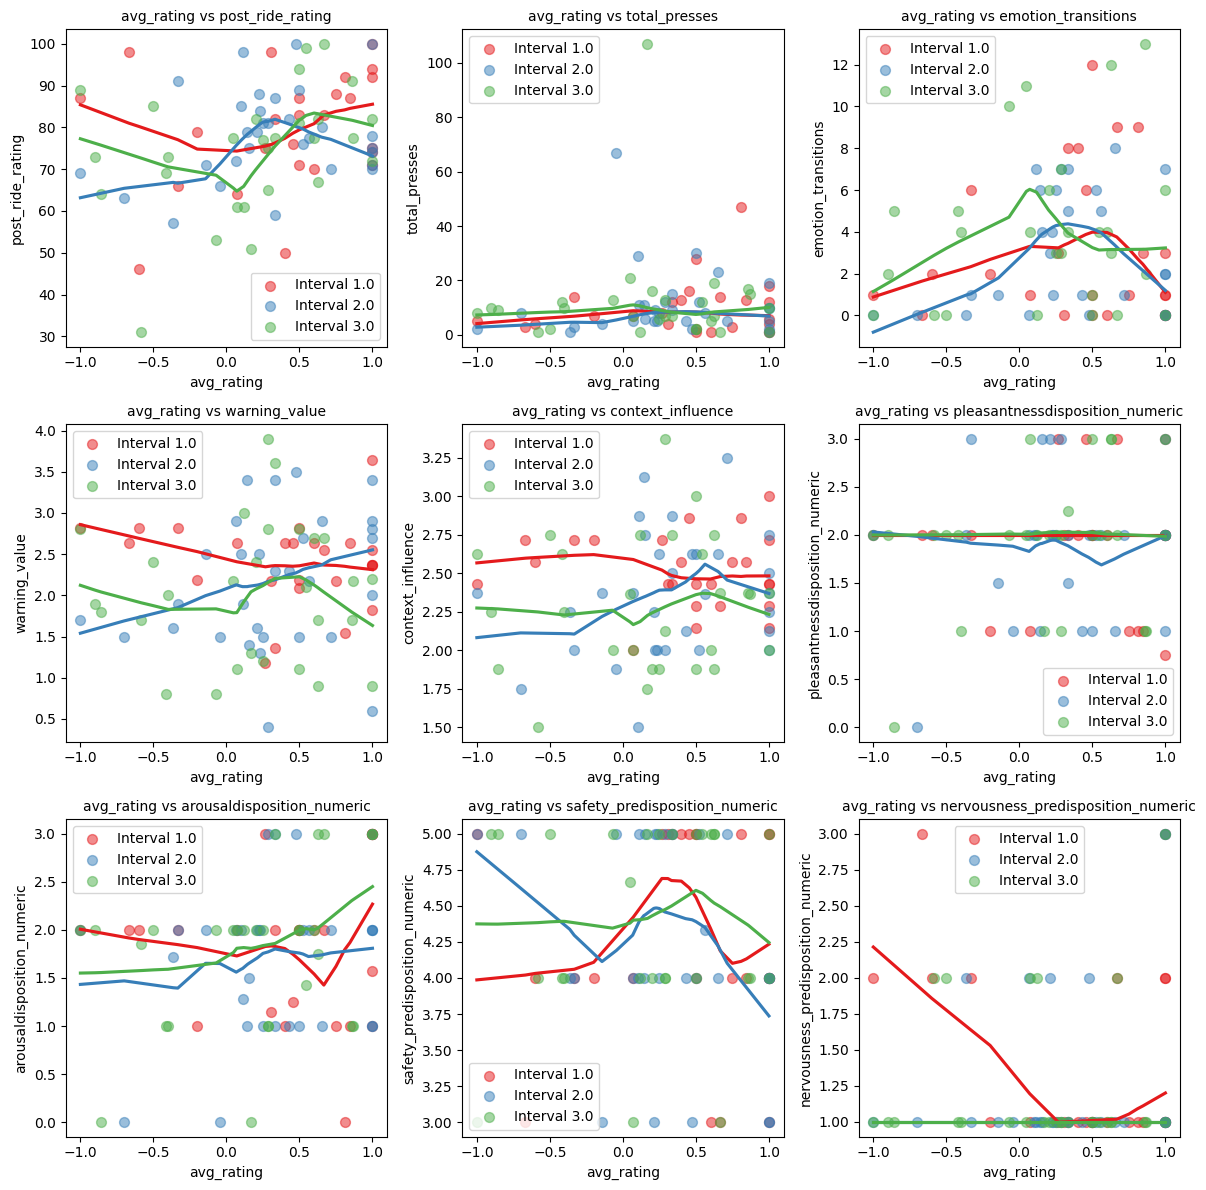

In [6]:

# List of relationships to plot based on the given formula
plot_relations = [
    ('avg_rating', 'post_ride_rating'),
    ('avg_rating', 'total_presses'),
    #('avg_rating', 'rating_variance'),
    #('avg_rating', 'rating_range'),
    ('avg_rating', 'emotion_transitions'),
    #('avg_rating', 'press_intensity'),
    ('avg_rating', 'warning_value'),
    ('avg_rating', 'context_influence'),
    #('avg_rating', 'flow'),
    #('avg_rating', 'safety'),
    ('avg_rating', 'pleasantnessdisposition_numeric'),
    ('avg_rating', 'arousaldisposition_numeric'),
    ('avg_rating', 'safety_predisposition_numeric'),
    ('avg_rating', 'nervousness_predisposition_numeric'),   
    #('avg_rating', 'flowdisposition_numeric')
    
]

# Determine grid size based on the number of relationships
num_plots = len(plot_relations)
cols = 3  # Keep 3 columns for readability
rows = int(np.ceil(num_plots / cols))  # Calculate required rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # Adjust height dynamically
axes = axes.flatten()  # Flatten the axes array for easy iteration


# Iterate through the list of relationships and plot the scatterplots with LOWESS curves
for idx, (x_col, y_col) in enumerate(plot_relations):
    # Create a filtered dataset if 'emotion_transitions' is involved
    if y_col == 'emotion_transitions' or x_col == 'emotion_transitions':
        data = avg_ratings[avg_ratings['emotion_transitions'] <= 15]
    else:
        data = avg_ratings
    
    # Plot with color based on interval_id
    palette = sns.color_palette('Set1', n_colors=len(data['interval_id'].unique()))
    for i, interval in enumerate(sorted(data['interval_id'].unique())):
        subset = data[data['interval_id'] == interval]
        sns.regplot(data=subset, x=x_col, y=y_col, ax=axes[idx], 
                    scatter_kws={'s': 50, 'color': palette[i], 'alpha': 0.5}, lowess=True, 
                    line_kws={'color': palette[i]}, 
                    label=f'Interval {interval}')
    
    axes[idx].set_title(f'{x_col} vs {y_col}', fontsize=10)
    axes[idx].legend()

# Hide any unused subplots (we only have 6 plots, but the grid is 3x3)
for idx in range(len(plot_relations), len(axes)):
    axes[idx].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()